## What is a trip - grouping user  searches/watches into “trips”

In [1]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.options.mode.chained_assignment = None
from kmodes.kmodes import KModes
from sklearn import preprocessing
import itertools

### Data Preprocessing

In [2]:
import tarfile

tar = tarfile.open("search_sample_data.tar.gz", "r:gz")
for tarinfo in tar:
    print(tarinfo.name, "is", tarinfo.size, "bytes in size and is ", end="")
    if tarinfo.isreg():
        print("a regular file.")
    elif tarinfo.isdir():
        print("a directory.")
    else:
        print("something else.")
tar.close()

search_sample_data is 0 bytes in size and is a directory.
search_sample_data/watch_sample.csv is 431395288 bytes in size and is a regular file.
search_sample_data/airports.csv is 661649 bytes in size and is a regular file.


In [3]:
tar = tarfile.open("search_sample_data.tar.gz", "r:gz")
tar.extractall()
tar.close()

In [4]:
watch_df = pd.read_csv('search_sample_data/watch_sample.csv')
airport_df = pd.read_csv('search_sample_data/airports.csv')

Merge two dataframes.

In [5]:
merged_df = pd.merge(watch_df, airport_df[['location_id', 'airport_group', 'country', 'region', 'latitude', 'longitude']], how='left', left_on='origin', right_on='location_id').drop(columns = ['location_id'])
merged_df = merged_df.rename(columns={'airport_group': 'origin_airport_group', 'country': 'origin_country', 'region': 'origin_region', 'latitude': 'origin_latitude', 'longitude': 'origin_longitude'})

merged_df = pd.merge(merged_df, airport_df[['location_id', 'airport_group', 'country', 'region', 'latitude', 'longitude']], how='left', left_on='destination', right_on='location_id').drop(columns = ['location_id'])
merged_df = merged_df.rename(columns={'airport_group': 'dest_airport_group', 'country': 'dest_country', 'region': 'dest_region', 'latitude': 'dest_latitude', 'longitude': 'dest_longitude'})

We are going to segment these searches by trips, so I removed the duplicate trips.

In [6]:
print('duplicate trip id: {}'.format(merged_df['trip_id'].duplicated().sum()))

duplicate trip id: 51735


In [7]:
merged_df.drop_duplicates(subset ='trip_id', keep = 'last', inplace = True)

I believe it makes sense to start with personalizing, or making recommendations to users who add "watch" during their search. Because:  

* The more we know about the user the better we can personalize the message to fit their interests.
* When an user add "watch", this indicates he (or she) is interested in this trip and would like to receive notifications on the update of the trip price.
* There are over 31% of these searches that user added "watch", I will use these searches for the segmentation prototype.

In [8]:
1 - merged_df['watch_added_dt'].isnull().sum() / merged_df.shape[0]

0.3127309859281089

In [9]:
df = merged_df[pd.notnull(merged_df['watch_added_dt'])]

In [10]:
df['origin_country'].value_counts() / df.shape[0]

United States    0.77194
Canada           0.06268
Puerto Rico      0.01669
Mexico           0.01283
United Kingdom   0.01187
                   ...  
Mongolia         0.00000
American Samoa   0.00000
Cote d'Ivoire    0.00000
Somalia          0.00000
Libya            0.00000
Name: origin_country, Length: 170, dtype: float64

Over 77% of these searches were originated from the United States, I believe it makes sense to segment these trips (originated from the US) first. Because: 
* I want to use US public holidays as a feature; 
* Travel behaviors are different between travelers from different countries / regions.

In [11]:
us_search = df.loc[df['origin_country'] == 'United States']

In [12]:
us_search[['stay', 'lowest_price', 'first_price']].isnull().sum() / us_search.shape[0]

stay           0.16410
lowest_price   0.00115
first_price    0.00115
dtype: float64

*About missing values*

16% of the number of stays are missing because it was a one-way trip, so I decided to fill missing stay with median values. 0.1% of searches have no price in it, I believe price is one of the most important elements for trip segmentation. I decided to remove thoes rows with missing prices.

In [13]:
us_search['stay'].fillna((us_search['stay'].median()), inplace=True)
us_search = us_search[pd.notnull(us_search['first_price'])]

Add a new feature - booking window.

In [14]:
for i in ['departure_date', 'first_searched_dt']:
    us_search[i] = pd.to_datetime(us_search[i])
us_search['first_searched_dt'] = us_search['first_searched_dt'].dt.date
us_search['first_searched_dt'] = pd.to_datetime(us_search['first_searched_dt'])

us_search['booking_window'] = (us_search['departure_date'] - us_search['first_searched_dt']).dt.days

In [15]:
us_search[['stay', 'booking_window', 'first_price', 'lowest_price']].describe().T

,count,mean,std,min,25%,50%,75%,max
stay,269203.00000,6.81171,9.04457,0.00000,3.00000,5.00000,7.00000,305.00000
booking_window,269203.00000,97.48869,72.57400,0.00000,41.00000,79.00000,139.00000,356.00000
first_price,269203.00000,432.30680,340.91134,34.00000,220.00000,336.00000,530.00000,15141.00000
lowest_price,269203.00000,380.73623,299.67273,24.00000,190.00000,296.00000,472.00000,14205.00000


In [16]:
us_search.loc[us_search['stay'] == 0].shape[0] / us_search.shape[0], us_search.loc[us_search['booking_window'] == 0].shape[0] / us_search.shape[0]

(0.0031351805143330497, 0.0014598648603470243)

*Observations*

In the data, the first price and lowest price are pretty close.

Approx. 0.3% of these trips were for the same day departure and return. And another 0.1% of trips were looking to leave ASAP (i.e.first search day and departure day were the same day).

Add a new column for flight routes.

In [17]:
us_search['route'] = us_search['origin']+' to '+us_search['destination']

In [18]:
pd.DataFrame([{'trips': len(us_search['trip_id'].value_counts()),    
               'departure dates': len(us_search['departure_date'].value_counts()),
               'routes': len(us_search['route'].value_counts()),
               'destination countries': len(us_search['dest_country'].value_counts())
              }], columns = ['trips', 'departure dates', 'routes', 'destination countries'], index = ['count'])

,trips,departure dates,routes,destination countries
count,269203,773,25696,178


The data contains 269,203 trips with 25,696 different flight routes and 773 different departure dates to 178 destination countries.

I would like to create a new feature

* US public holidays

In [19]:
print(f' Search departure date minimum value {us_search.departure_date.min()}')
print(f' Search departure date maximum value {us_search.departure_date.max()}')

 Search departure date minimum value 2018-01-01 00:00:00
 Search departure date maximum value 2020-03-01 00:00:00


The top searched travel date is around memorial day, followed by Christmas, and Wed prior to US thanksgiving is the busiest travel day in the US.

In [20]:
us_search['departure_date'].value_counts()[:20]

2018-05-25    1682
2018-12-21    1656
2018-12-22    1405
2018-11-21    1327
2018-05-24    1322
2018-08-31    1304
2018-04-20    1283
2018-06-01    1246
2018-05-04    1244
2018-03-23    1237
2018-05-11    1204
2018-03-30    1181
2018-06-15    1168
2018-06-22    1150
2018-06-29    1148
2018-04-19    1136
2018-05-17    1130
2018-04-13    1117
2018-03-29    1102
2018-06-08    1098
Name: departure_date, dtype: int64

In [21]:
us_search.loc[(us_search['departure_date'] >= '2018-05-24') & (us_search['departure_date'] <= '2018-05-26'), 'holiday'] = 'Memorial'
us_search.loc[(us_search['departure_date'] >= '2019-05-23') & (us_search['departure_date'] <= '2019-05-25'), 'holiday'] = 'Memorial'

us_search.loc[(us_search['departure_date'] >= '2018-07-02') & (us_search['departure_date'] <= '2018-07-04'), 'holiday'] = 'Independence'
us_search.loc[(us_search['departure_date'] >= '2019-07-02') & (us_search['departure_date'] <= '2019-07-04'), 'holiday'] = 'Independence'

us_search.loc[(us_search['departure_date'] >= '2018-08-30') & (us_search['departure_date'] <= '2018-09-01'), 'holiday'] = 'Labor'
us_search.loc[(us_search['departure_date'] >= '2019-08-29') & (us_search['departure_date'] <= '2019-08-31'), 'holiday'] = 'Labor'

us_search.loc[(us_search['departure_date'] >= '2018-11-20') & (us_search['departure_date'] <= '2018-11-21'), 'holiday'] = 'Thanksgiving'
us_search.loc[(us_search['departure_date'] >= '2019-11-26') & (us_search['departure_date'] <= '2019-11-27'), 'holiday'] = 'Thanksgiving'

us_search.loc[(us_search['departure_date'] >= '2018-12-21') & (us_search['departure_date'] <= '2018-12-24'), 'holiday'] = 'Christmas'
us_search.loc[(us_search['departure_date'] >= '2019-12-20') & (us_search['departure_date'] <= '2019-12-21'), 'holiday'] = 'Christmas'

In [22]:
us_search['holiday'].fillna('Normal', inplace=True)

When we segment trips, what are important factors for characterize a "trip"? Let's focus on the following features.

* Weekends or weekdays
* Destinations
* Flight routes
* Booking window
* How long they stay
* Price
* Holdiay or not

## EDA

76% of these trips were for weekday departures.

In [23]:
us_search['weekend'].value_counts() / us_search.shape[0]

0   0.75966
1   0.24034
Name: weekend, dtype: float64

60% of the recommendations were "wait".

In [24]:
us_search['first_rec'].value_counts() / us_search.shape[0]

wait   0.60775
buy    0.39225
Name: first_rec, dtype: float64

According to current available data, more then 68% of these searches were about traveling within the country, 10% of these searches were about traveling to Europe. And so on.

In [25]:
us_search['dest_region'].value_counts()/us_search.shape[0]

United States                0.68452
Europe                       0.10145
Antilles                     0.05666
Mexico and Central America   0.05468
Asia                         0.04725
South America                0.02035
Canada                       0.01592
Africa and Mideast           0.01219
Oceania                      0.00638
Russia                       0.00061
Name: dest_region, dtype: float64

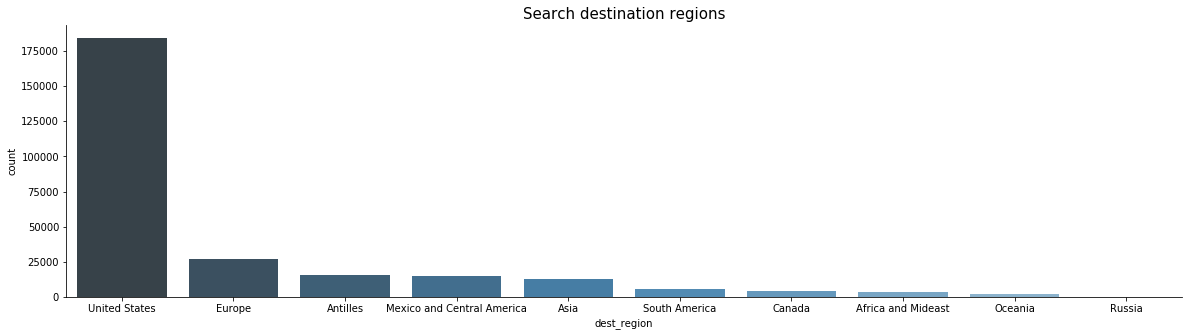

In [27]:
plt.figure(figsize=(20,5))
sns.countplot(x='dest_region', data=us_search, order=us_search['dest_region'].value_counts().index, palette="Blues_d")
plt.title('Search destination regions', size=15)
sns.despine();

Top 20 searched routes.

19 of these top 20 searched routes were within the US. Only one is from NYC to Paris.

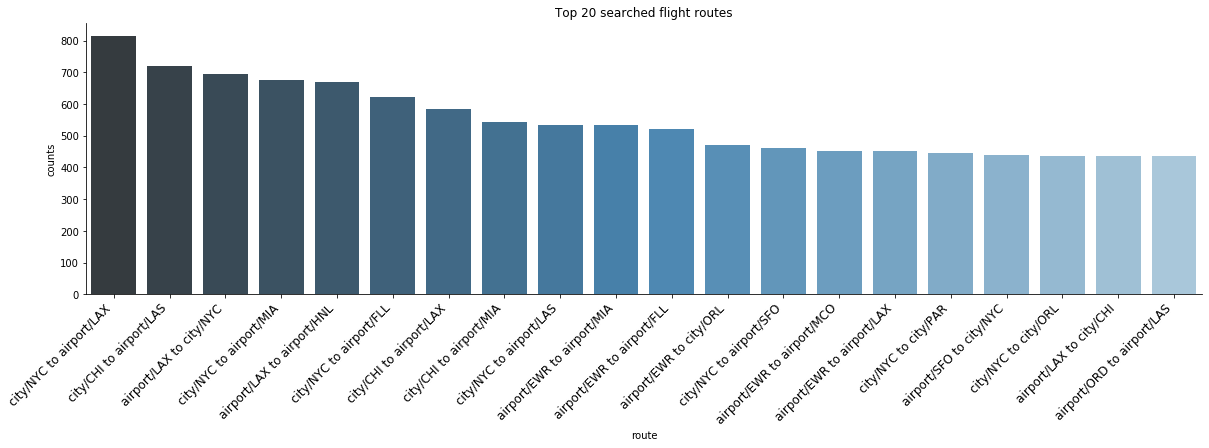

In [28]:
plt.figure(figsize=(20,5))
top_routes = us_search['route'].value_counts()[:20].rename_axis('route').reset_index(name='counts')
sns.barplot("route", y="counts", data=top_routes, palette="Blues_d")
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
plt.title('Top 20 searched flight routes', size=12)
sns.despine();

An interesting observation is that 12 of these top 20 routes are from NYC to somewhere, mostly to somewhere warm within the country, only one from NYC to Paris

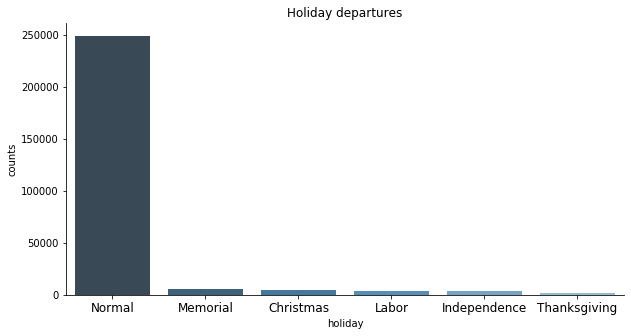

In [29]:
plt.figure(figsize=(10,5))
holiday_df = us_search['holiday'].value_counts().rename_axis('holiday').reset_index(name='counts')
sns.barplot("holiday", y="counts", data=holiday_df, palette="Blues_d")
plt.xticks(fontsize='large')
plt.title('Holiday departures', size=12)
sns.despine();

I had a feeling that the users are not likely to travel during busy holiday travel seasons probably because of the high-season prices.

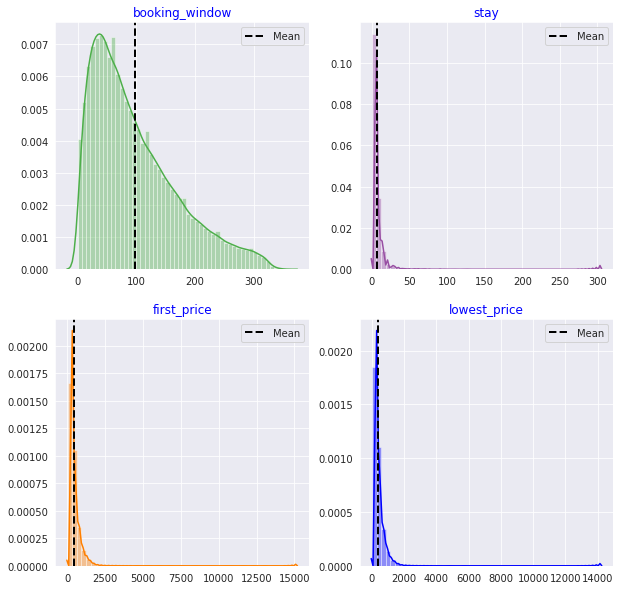

In [30]:
cols = ['booking_window', 'stay', 'first_price', 'lowest_price']
length = len(cols)
cs     = [(0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
          (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
          (1.0, 0.4980392156862745, 0.0),"b"]

sns.set_style("darkgrid")
plt.figure(figsize = (10,10))
for i,j,k in itertools.zip_longest(cols,range(length), cs):
    plt.subplot(length/2,length/2,j+1)
    sns.distplot(us_search[i],color = k)
    plt.axvline(us_search[i].mean(),linewidth  = 2 ,
                linestyle = "dashed",color = "k" ,
                label = "Mean")
    plt.legend(loc = "best")
    plt.title(i,color = "b")
    plt.xlabel("");

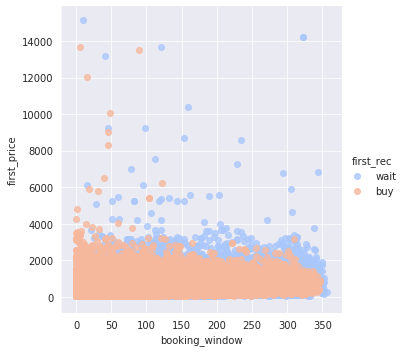

In [31]:
sns.lmplot('booking_window','first_price',data=us_search, hue='first_rec', palette='coolwarm',height=5,aspect=1,fit_reg=False);

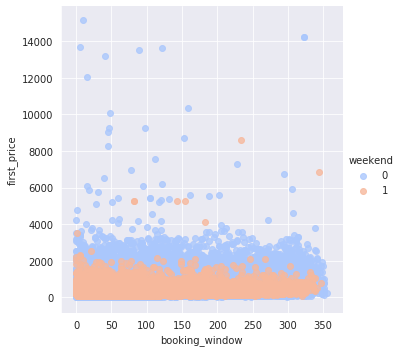

In [32]:
sns.lmplot('booking_window','first_price',data=us_search, hue='weekend', palette='coolwarm',height=5,aspect=1,fit_reg=False);

In [33]:
us_search[['first_price', 'lowest_price']].describe()

,first_price,lowest_price
count,269203.00000,269203.00000
mean,432.30680,380.73623
std,340.91134,299.67273
min,34.00000,24.00000
25%,220.00000,190.00000
50%,336.00000,296.00000
75%,530.00000,472.00000
max,15141.00000,14205.00000


First price and lowest price are pretty close. I will use lowest price from now on.

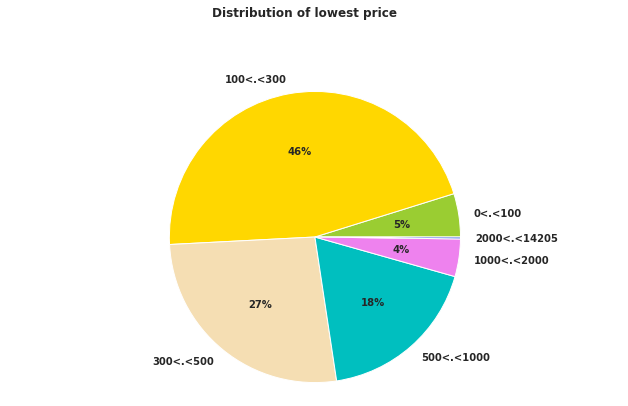

In [34]:
price_range = [0, 100, 300, 500, 1000, 2000, 14205]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = us_search[(us_search['lowest_price'] < price) &
                       (us_search['lowest_price'] > price_range[i-1])]['lowest_price'].count()
    count_price.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of lowest price", ha='center', fontsize = 12);

We can see that 73% of these trips are in the price range at 100 to 500 dollars.

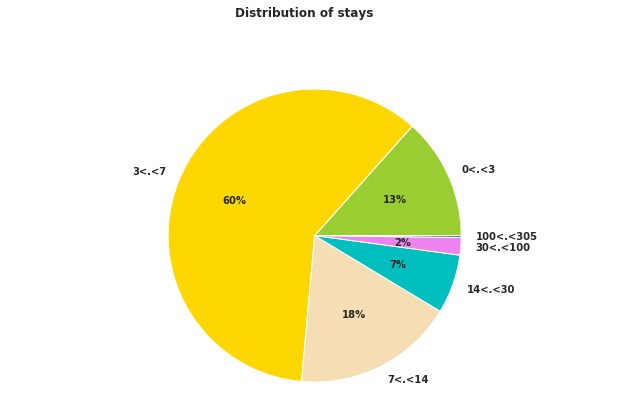

In [35]:
stay_range = [0, 3, 7, 14, 30, 100, 305]
count_stay = []
for i, stay in enumerate(stay_range):
    if i == 0: continue
    val = us_search[(us_search['stay'] < stay) &
                       (us_search['stay'] > stay_range[i-1])]['stay'].count()
    count_stay.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(stay_range[i-1], s) for i,s in enumerate(stay_range) if i != 0]
sizes  = count_stay
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of stays", ha='center', fontsize = 12);

73% of these trips are in the stay range at 0 to 7 days.

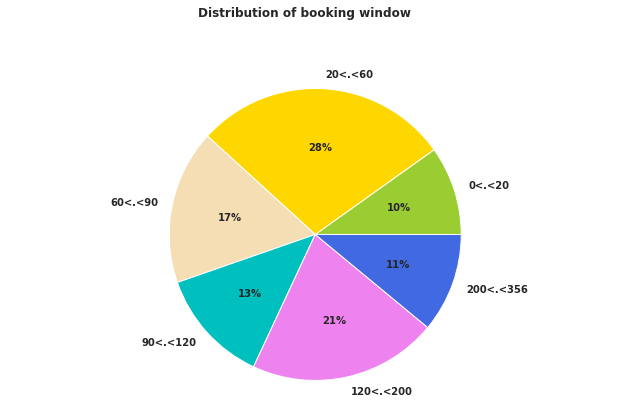

In [36]:
booking_window_range = [0, 20, 60, 90, 120, 200, 356]
count_booking_window = []
for i, booking_window in enumerate(booking_window_range):
    if i == 0: continue
    val = us_search[(us_search['booking_window'] < booking_window) &
                       (us_search['booking_window'] > booking_window_range[i-1])]['booking_window'].count()
    count_booking_window.append(val)
       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(booking_window_range[i-1], s) for i,s in enumerate(booking_window_range) if i != 0]
sizes  = count_booking_window
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of booking window", ha='center', fontsize = 12);

55% of these trips are in the booking window range at 0 to 90 days.

## K-Mode Clustering

Create bins for all the numeric features.

In [37]:
us_search['stay_bin'] = pd.cut(us_search['stay'], [-1, 3, 7, 14, 30, 100, 305], 
                               labels=['0-3', '3-7', '7-14', '14-30','30-100','100-305'])

us_search['lowest_price_bin'] = pd.cut(us_search['lowest_price'], [0, 100, 300, 500, 1000, 2000, 14205], 
                              labels=['0-100', '100-300', '300-500', '500-1000','1000-2000','2000-14205'])

us_search['booking_window_bin'] = pd.cut(us_search['booking_window'], [-1, 20, 60, 90, 120, 200, 356], 
                              labels=['0-20', '20-60', '60-90', '90-120','120-200','200-356'])

In [38]:
us_search_clean_1 = us_search[['weekend', 'dest_region', 'route', 'holiday', 'stay_bin', 'lowest_price_bin', 'booking_window_bin', 'stay', 'lowest_price', 'booking_window']]

In [39]:
us_search_clean_1.isnull().sum()

weekend               0
dest_region           0
route                 0
holiday               0
stay_bin              0
lowest_price_bin      0
booking_window_bin    0
stay                  0
lowest_price          0
booking_window        0
dtype: int64

In [40]:
us_search_clean_copy = us_search_clean_1.copy()

In [41]:
us_search_clean = us_search[['weekend', 'dest_region', 'route', 'holiday', 'stay_bin', 'lowest_price_bin', 'booking_window_bin']]

In [42]:
le = preprocessing.LabelEncoder()
us_search_clean = us_search_clean.apply(le.fit_transform)
us_search_clean.head()

,weekend,dest_region,route,holiday,stay_bin,lowest_price_bin,booking_window_bin
1,0,9,24039,4,3,4,1
3,1,9,18950,4,0,1,2
5,0,9,10728,4,3,1,2
8,0,5,15099,4,3,4,2
11,0,9,23506,4,3,0,2


In [43]:
cost = []
for num_clusters in list(range(1,6)):
    kmode = KModes(n_clusters=num_clusters, init = 'Cao', verbose=1)
    kmode.fit_predict(us_search_clean)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 904006.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 815646.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14959, cost: 738494.0
Run 1, iteration: 2/100, moves: 3035, cost: 738494.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 16986, cost: 713914.0
Run 1, iteration: 2/100, moves: 0, cost: 713914.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 15220, cost: 705659.0
Run 1, iteration: 2/100, moves: 61, cost: 705659.0


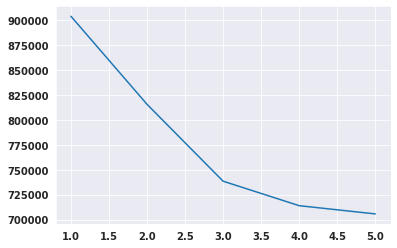

In [44]:
y = np.array([i for i in range(1,6,1)])
plt.plot(y,cost);

Choose k=3

In [45]:
km_cao = KModes(n_clusters=3, init = "Cao", verbose=1)
fitClusters_cao = km_cao.fit_predict(us_search_clean)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14959, cost: 738494.0
Run 1, iteration: 2/100, moves: 3035, cost: 738494.0


In [46]:
us_search_clean = us_search_clean_copy.reset_index()

segment_df = pd.DataFrame(fitClusters_cao)
segment_df.columns = ['segment_predicted']
combined_df = pd.concat([us_search_clean, segment_df], axis = 1).reset_index()
combined_df = combined_df.drop(['index', 'level_0'], axis = 1)

Segment by destination regions.

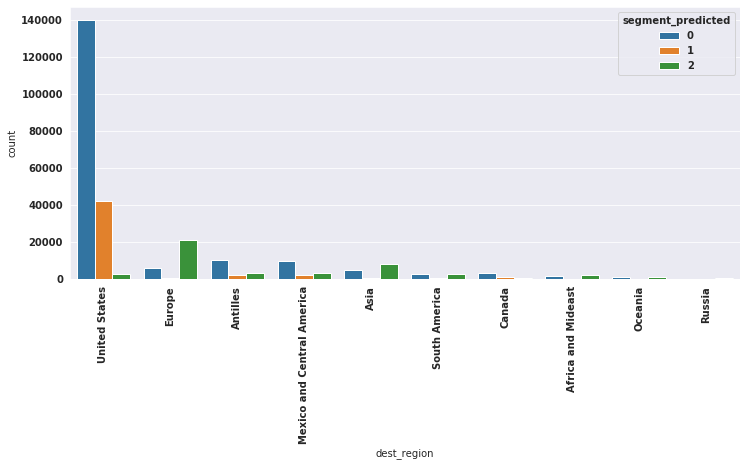

In [48]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['dest_region'],order=combined_df['dest_region'].value_counts().index,hue=combined_df['segment_predicted'])
plt.xticks(rotation=90)
plt.show();

Segment by flight routes.

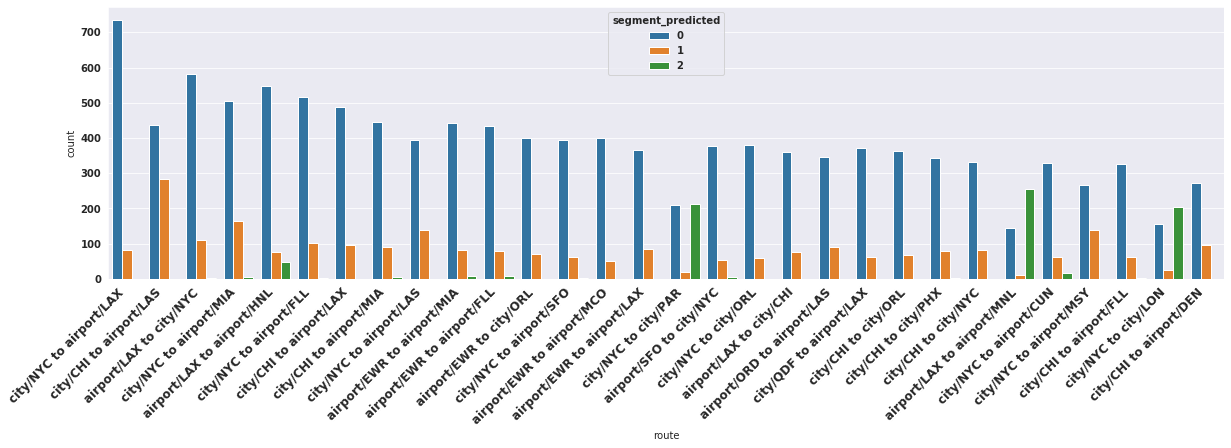

In [49]:
plt.subplots(figsize = (20,5))
sns.countplot(x=combined_df['route'],order=combined_df['route'].value_counts()[:30].index,hue=combined_df['segment_predicted'])
plt.xticks(rotation=45, horizontalalignment='right', fontsize='large')
plt.show();

Segment by US public holidays

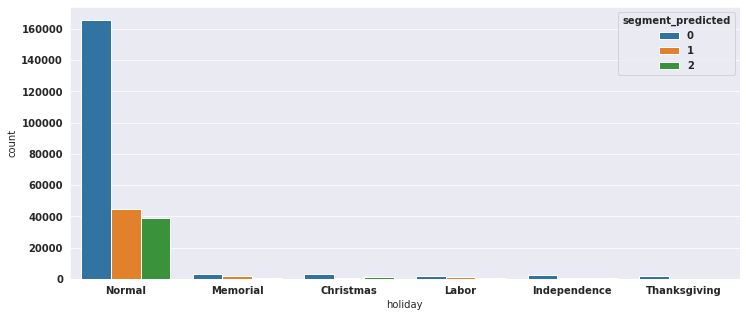

In [50]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['holiday'],order=combined_df['holiday'].value_counts().index,hue=combined_df['segment_predicted'])
plt.show();

Segment by weekends vs. weekdays

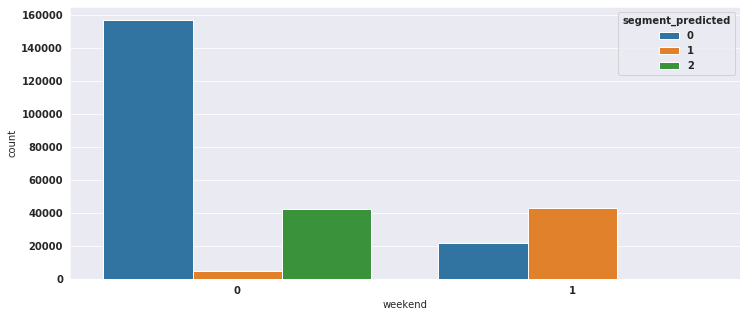

In [51]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['weekend'],order=combined_df['weekend'].value_counts().index,hue=combined_df['segment_predicted'])
plt.show();

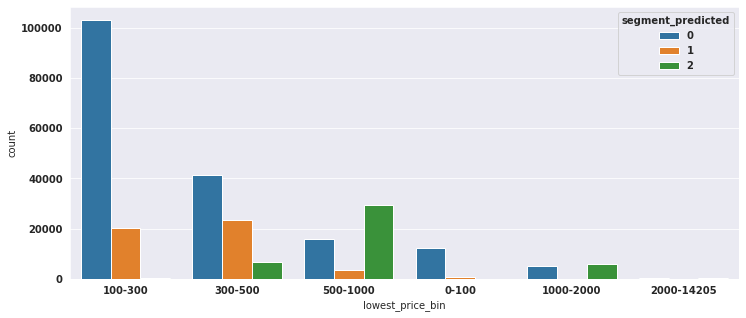

In [52]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['lowest_price_bin'],order=combined_df['lowest_price_bin'].value_counts().index,hue=combined_df['segment_predicted'])
plt.show();

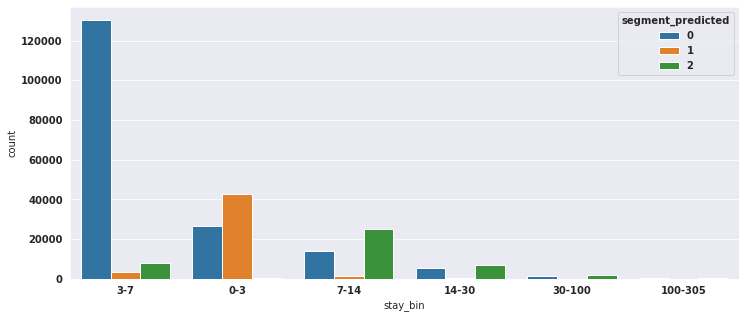

In [53]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['stay_bin'],order=combined_df['stay_bin'].value_counts().index,hue=combined_df['segment_predicted'])
plt.show();

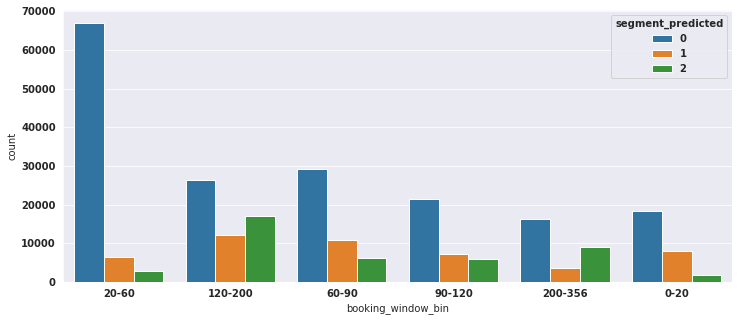

In [54]:
plt.subplots(figsize = (12,5))
sns.countplot(x=combined_df['booking_window_bin'],order=combined_df['booking_window_bin'].value_counts().index,hue=combined_df['segment_predicted'])
plt.show();

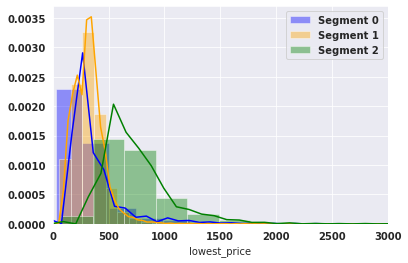

In [75]:
sns.distplot(combined_df.loc[combined_df['segment_predicted'] == 0]['lowest_price'] , color="blue", label="Segment 0")
sns.distplot(combined_df.loc[combined_df['segment_predicted'] == 1]['lowest_price'] , color="orange", label="Segment 1")
sns.distplot(combined_df.loc[combined_df['segment_predicted'] == 2]['lowest_price'] , color="green", label="Segment 2")
plt.xlim(0, 3000)
plt.legend();

In [72]:
print(combined_df.loc[combined_df['segment_predicted'] == 0]['lowest_price'].describe(), combined_df.loc[combined_df['segment_predicted'] == 1]['lowest_price'].describe(), combined_df.loc[combined_df['segment_predicted'] == 2]['lowest_price'].describe())

count   178519.00000
mean       310.67400
std        259.33362
min         24.00000
25%        163.00000
50%        246.00000
75%        366.00000
max      12035.00000
Name: lowest_price, dtype: float64 count   48101.00000
mean      319.78953
std       152.21355
min        57.00000
25%       218.00000
50%       314.00000
75%       387.00000
max      5263.00000
Name: lowest_price, dtype: float64 count   42583.00000
mean      743.29963
std       321.53337
min        74.00000
25%       539.00000
50%       675.00000
75%       876.00000
max     14205.00000
Name: lowest_price, dtype: float64


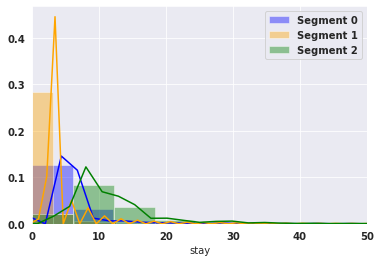

In [76]:
sns.distplot(combined_df.loc[combined_df['segment_predicted'] == 0]['stay'] , color="blue", label="Segment 0")
sns.distplot(combined_df.loc[combined_df['segment_predicted'] == 1]['stay'] , color="orange", label="Segment 1")
sns.distplot(combined_df.loc[combined_df['segment_predicted'] == 2]['stay'] , color="green", label="Segment 2")
plt.xlim(0, 50)
plt.legend();

In [77]:
print(combined_df.loc[combined_df['segment_predicted'] == 0]['stay'].describe(), combined_df.loc[combined_df['segment_predicted'] == 1]['stay'].describe(), combined_df.loc[combined_df['segment_predicted'] == 2]['stay'].describe())

count   178519.00000
mean         6.17189
std          7.68286
min          0.00000
25%          4.00000
50%          5.00000
75%          6.00000
max        303.00000
Name: stay, dtype: float64 count   48101.00000
mean        3.21436
std         3.49705
min         0.00000
25%         2.00000
50%         3.00000
75%         3.00000
max       156.00000
Name: stay, dtype: float64 count   42583.00000
mean       13.55750
std        13.93021
min         0.00000
25%         8.00000
50%        10.00000
75%        14.00000
max       305.00000
Name: stay, dtype: float64


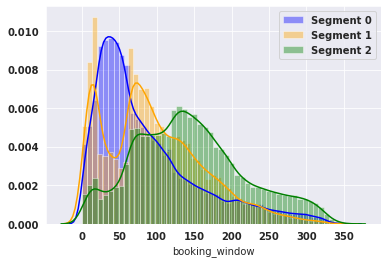

In [69]:
sns.distplot(combined_df.loc[combined_df['segment_predicted'] == 0]['booking_window'] , color="blue", label="Segment 0")
sns.distplot(combined_df.loc[combined_df['segment_predicted'] == 1]['booking_window'] , color="orange", label="Segment 1")
sns.distplot(combined_df.loc[combined_df['segment_predicted'] == 2]['booking_window'] , color="green", label="Segment 2")
plt.legend();

In [78]:
print(combined_df.loc[combined_df['segment_predicted'] == 0]['booking_window'].describe(), combined_df.loc[combined_df['segment_predicted'] == 1]['booking_window'].describe(), combined_df.loc[combined_df['segment_predicted'] == 2]['booking_window'].describe())

count   178519.00000
mean        86.54932
std         69.41991
min          0.00000
25%         36.00000
50%         64.00000
75%        117.00000
max        356.00000
Name: booking_window, dtype: float64 count   48101.00000
mean       96.34519
std        66.21101
min         0.00000
25%        44.00000
50%        87.00000
75%       137.00000
max       344.00000
Name: booking_window, dtype: float64 count   42583.00000
mean      144.64108
std        73.59190
min         0.00000
25%        90.00000
50%       139.00000
75%       189.00000
max       351.00000
Name: booking_window, dtype: float64


### Interpret the results

Segment 0: 
* The largest segment which contains 178,519 trips.
* They are mostly domestic routes within the United States, plus some routes from the US to Mexico or Antilles. 
* Most of these routes are likely to be from NYC or Chicago to somewhere warm, such as California, Florida or Nevada. 
* These trips are likely to depart on weekdays. 
* The average price is 310 dollars, and the average stay is about 6 days, and user’s average booking window is less than 3 months. 

So, the trips in Segment 0 sound like week-long vacations from the East to the sunny destinations. 

Segment 1: 
* This segment contains 48,101 trips.
* Trips in this segment are largely domestic trips as well. 
* These trips are likely to depart on the weekends, that including Memorial weekend and Labor day weekend; They are weekend Getaways for about 3 days. 
* Because it is a weekend Getaway, they are likely to flight short distance within the US. 
* The average price is 319 dollars.

So, the trips in Segment 1 are mostly quick weekend Getaways with relative short flight. They can be cheap, romantic or last minute, or just recharge from the hustle and bustle of the city life. 

Segment 2: 
* This segment contains 42,583 trips.
* Trips in this segment are likely to be international trips such as traveling from the US to Europe, Asia or domestic trips but traveling far away such as to Hawaii. 
* For this type of trips, the users tend to search departure on weekdays. 
* The average price is 743 dollars, and the average stay is around 14 days. 
* Users tend to plan earlier for long distance trips with average booking window at about 4–5 months. 

### How do we use this information?

Business will be able to provide an optimal experience for its users based on their intent by using above knowledge to create more effective content or recommendations. 
For example, once a user searches and watches a trip in Segment 1, the company would know this user is likely to look for a weekend Getaways, the company then can give travel advice on weekend Getaways or recommend other similar weekend Getaways destinations that currently have promotion on flights or hotels.